<a href="https://colab.research.google.com/github/HongJaeKwon/machine-learning/blob/master/HJK_PG_AC_CONTINUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필요한 모듈 설치
import tensorflow as tf
import tensorflow_probability as tfp
import gym
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
import math
%matplotlib inline

In [2]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np


class ContinuousCartPoleEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 30.0
        self.tau = 0.02  # seconds between state updates
        self.min_action = -1.0
        self.max_action = 1.0
        self.max_score=300
        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max])

        self.action_space = spaces.Box(
            low=self.min_action,
            high=self.max_action,
            shape=(1,)
        )
        self.observation_space = spaces.Box(-high, high)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
            (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        assert self.action_space.contains(action), \
            "%r (%s) invalid" % (action, type(action))
        # Cast action to float to strip np trappings
        force = self.force_mag * float(action)
        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state
        done = x < -self.x_threshold \
            or x > self.x_threshold \
            or theta < -self.theta_threshold_radians \
            or theta > self.theta_threshold_radians
        done = bool(done)
        
        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn("""
You are calling 'step()' even though this environment has already returned
done = True. You should always call 'reset()' once you receive 'done = True'
Any further steps are undefined behavior.
                """)
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width /world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * 1.0
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen-polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth / 2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

        if self.state is None:
            return None

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=(mode == 'rgb_array'))

    def close(self):
        if self.viewer:
            self.viewer.close()

In [3]:
# 카트폴 게임 환경을 만듦
env = ContinuousCartPoleEnv()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
env.reset()

array([ 0.02346691, -0.02746262,  0.02018036, -0.03060984])

In [5]:
# 2 - 액션 종류 슈 (아웃풋)
action_num=env.action_space.shape[0]
# 4 - 상태 종류 수 (인풋)
state_num=env.observation_space.shape[0]

In [6]:
action_num,state_num

(1, 4)

In [7]:
# pg 모델 만들기 - REINFORCE 알고리즘(가장 기초)
i=tf.keras.Input(shape=(state_num,))
out=tf.keras.layers.Dense(128,activation='relu')(i)
out=tf.keras.layers.Dense(128,activation='relu')(out)
mu=tf.keras.layers.Dense(128,activation='relu')(out)
mu=tf.keras.layers.Dense(action_num,name='mu')(mu)
sigma=tf.keras.layers.Dense(128,activation='relu')(out)
sigma=tf.keras.layers.Dense(action_num,activation='softplus',name='sigma')(sigma)
sigma=tf.keras.layers.Lambda(lambda x : x + 0.1)(sigma)
pg_model=tf.keras.Model(inputs=[i],outputs=[mu,sigma])

In [8]:
opt=tf.keras.optimizers.Adam(0.0001,clipnorm=0.1)

In [9]:
# pg 모델 만들기 - REINFORCE 알고리즘(가장 기초)
i=tf.keras.Input(shape=(state_num,))
out=tf.keras.layers.Dense(128,activation='relu')(i)
out=tf.keras.layers.Dense(64,activation='relu')(out)
out=tf.keras.layers.Dense(16,activation='relu')(out)
val=tf.keras.layers.Dense(action_num,name='val')(out)
val_model=tf.keras.Model(inputs=[i],outputs=[val])

In [10]:
opt_2=tf.keras.optimizers.Adam(0.001,clipnorm=0.1)

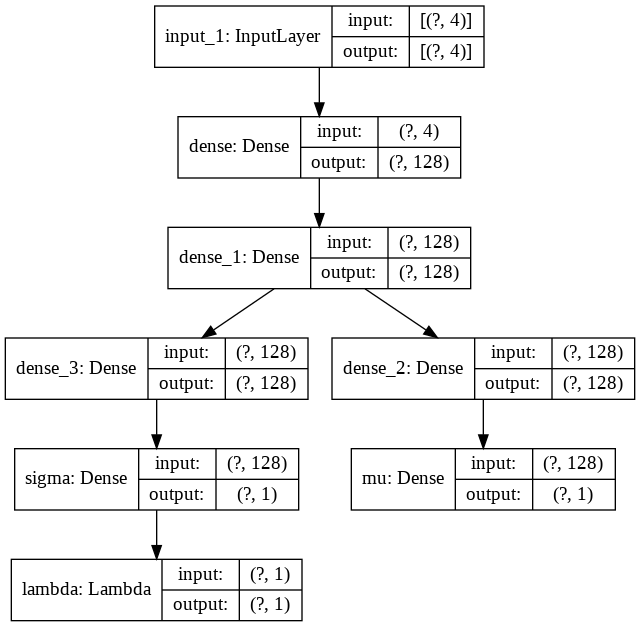

In [11]:
tf.keras.utils.plot_model(pg_model,show_shapes=True)

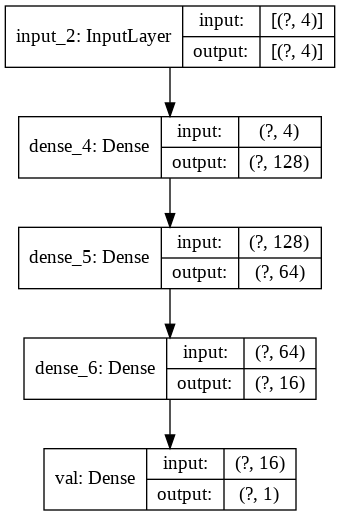

In [12]:
tf.keras.utils.plot_model(val_model,show_shapes=True)

In [13]:
# 에피소드 수만큼 학습
episode_count=1000

# 점수를 기록할 리스트
scores = []

# 디스카운트 팩터 정의
discount_rate=0.99
batch_size=16
grad_t=[]
grad_t_v=[]
count=0

for episode in range(episode_count):
    state = env.reset()
    # 차원을 맞추어 준다
    state = np.reshape(state, [1, state_num])
    done = False
    total_reward = 0
    while not done:
        count=count+1
        mu,sigma=pg_model.predict(state)
        mu=mu[0]
        sigma=sigma[0]
        dist=tfp.distributions.Normal(loc=mu,scale=sigma)
        action=dist.sample()
        _action=tf.clip_by_value(action,-1.0,1.0)
        next_state, reward, done, _ = env.step(_action)
        next_state = np.reshape(next_state, [1, state_num])
        reward=reward/100.
   
        v = pg_model.trainable_variables
        
        with tf.GradientTape() as tape:
            mu,sigma=pg_model(state)
            val=val_model(state)
            n_val=val_model(next_state)
            mu=mu[0]
            sigma=sigma[0]
            dist=tfp.distributions.Normal(loc=mu,scale=sigma)
            p=dist.prob(action)[0]
            td=reward + (1-done) * discount_rate * n_val[0]
            tde=tf.stop_gradient(td-val[0])
            loss = - tf.math.log(p) * tde
        grad=tape.gradient(loss,v)
        grad_t.append(grad)
        
        v_2 = val_model.trainable_variables
        
        with tf.GradientTape() as tape:
            val=val_model(state)
            n_val=val_model(next_state)
            td=reward + (1-done) * discount_rate * n_val[0]
            tde=tf.stop_gradient(td)-val[0]
            loss = tf.square(tde)
        grad=tape.gradient(loss,v_2)
        grad_t_v.append(grad)

        if(count%batch_size==0):
            opt.apply_gradients(zip(np.sum(grad_t,axis=0),v))
            opt_2.apply_gradients(zip(np.sum(grad_t_v,axis=0),v_2))
            grad_t=[]
            grad_t_v=[]

        state = next_state
        total_reward += reward*100.
        if(total_reward>=200):
            print("성공")
            break
    
    scores.append(total_reward)
    if(episode%20==0):
        print(episode+1,np.mean(scores[-30:]))
    

1 7.0
21 17.238095238095237
41 16.133333333333333
61 19.466666666666665
81 20.8
101 25.4
121 31.0
141 34.56666666666667
161 45.13333333333333
181 75.83333333333333
성공
성공
201 111.16666666666667
성공
성공
성공


KeyboardInterrupt: ignored

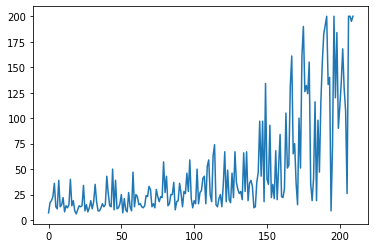

In [14]:
plt.plot(scores)